## Data Pre-processing

In [8]:
lifeData_original <- read.csv("C:/Code/BIOSTAT682/Life Expectancy Data.csv")
head(lifeData_original)

,Country,Year,Status,Life.expectancy,Adult.Mortality,infant.deaths,Alcohol,percentage.expenditure,Hepatitis.B,Measles,⋯,Polio,Total.expenditure,Diphtheria,HIV.AIDS,GDP,Population,thinness..1.19.years,thinness.5.9.years,Income.composition.of.resources,Schooling
,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,⋯,6,8.16,65,0.1,584.25921,33736494,17.2,17.3,0.479,10.1
2,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,⋯,58,8.18,62,0.1,612.69651,327582,17.5,17.5,0.476,10.0
3,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,⋯,62,8.13,64,0.1,631.74498,31731688,17.7,17.7,0.470,9.9
4,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,⋯,67,8.52,67,0.1,669.95900,3696958,17.9,18.0,0.463,9.8
5,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,⋯,68,7.87,68,0.1,63.53723,2978599,18.2,18.2,0.454,9.5
6,Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,⋯,66,9.20,66,0.1,553.32894,2883167,18.4,18.4,0.448,9.2


In [9]:
library(tidyr)

lifeData_full <- lifeData_original %>% drop_na()

In [10]:
lifeData <- lifeData_full[1:500,]
dim(lifeData)

[1] 500  22

Warning message:
"package 'corrplot' was built under R version 4.2.2"
corrplot 0.92 loaded



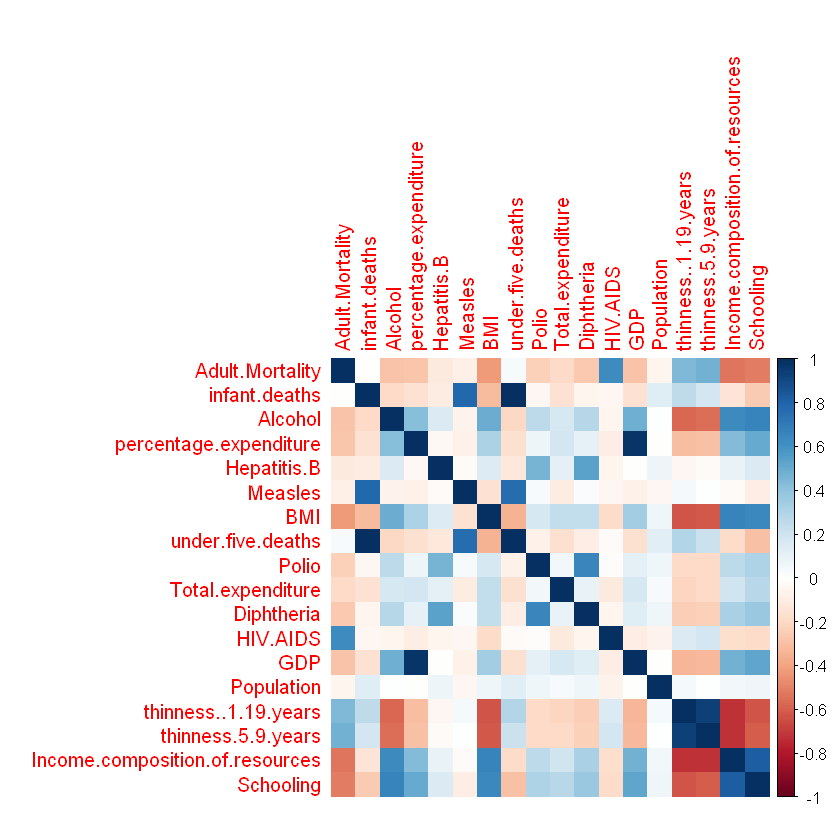

In [11]:
# generate correlation plot

lifeData_Matrix <- as.matrix(lifeData)[,-(1:4)]
lifeData_Matrix.numeric <- apply(lifeData_Matrix, 2, as.numeric)  # element in original matrix is character

library(corrplot)
corrplot(cor(lifeData_Matrix.numeric), method="color")

## Frequentist Way

In [12]:
lmod <- lm(Life.expectancy ~ . - Country, data = lifeData)
summary(lmod)


Call:
lm(formula = Life.expectancy ~ . - Country, data = lifeData)

Residuals:
   Min     1Q Median     3Q    Max 
-9.403 -1.837  0.019  1.884  9.123 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      1.546e+02  7.564e+01   2.044 0.041482 *  
Year                            -4.617e-02  3.789e-02  -1.219 0.223616    
StatusDeveloping                -1.865e+00  5.299e-01  -3.520 0.000472 ***
Adult.Mortality                 -2.039e-02  1.856e-03 -10.989  < 2e-16 ***
infant.deaths                    4.002e-01  3.574e-02  11.198  < 2e-16 ***
Alcohol                         -1.170e-01  5.606e-02  -2.088 0.037356 *  
percentage.expenditure           8.236e-04  3.429e-04   2.401 0.016711 *  
Hepatitis.B                     -1.250e-02  6.566e-03  -1.903 0.057608 .  
Measles                         -2.212e-05  1.923e-05  -1.151 0.250500    
BMI                              3.087e-02  1.031e-02   2.994 0.002900 ** 
under.fi

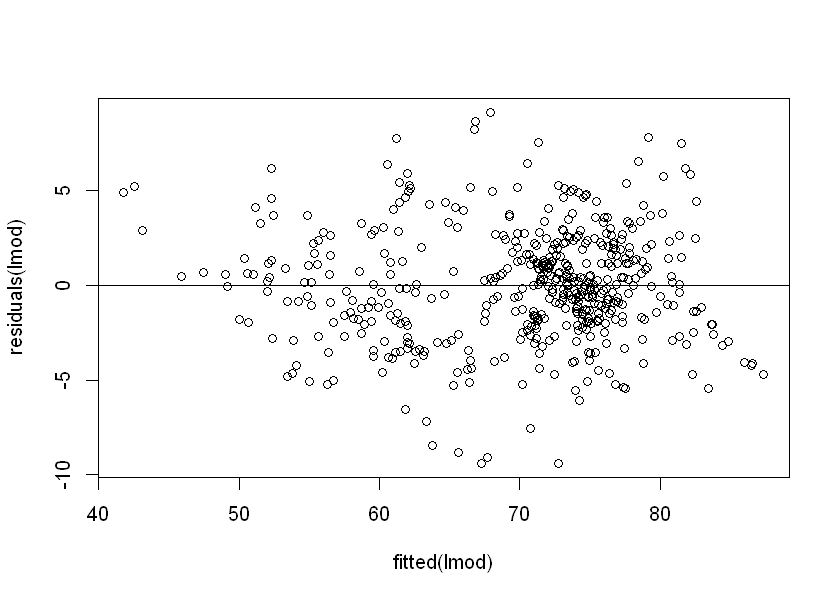

In [17]:
options(repr.plot.width = 7, repr.plot.height = 5)

plot(fitted(lmod), residuals(lmod))
abline(h = 0)

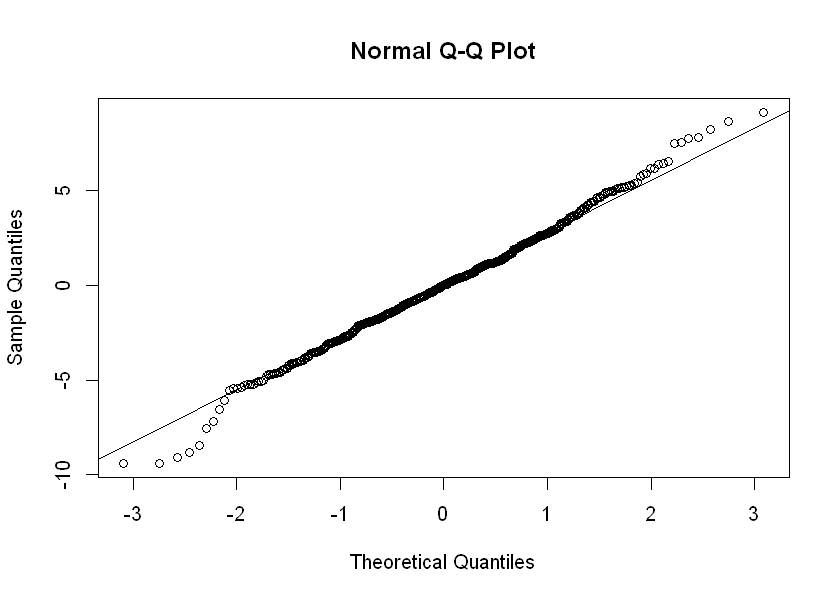

In [18]:
qqnorm(residuals(lmod))
qqline(residuals(lmod))

In [15]:
# library(quantreg)
# ladmod <- rq(Life.expectancy ~ . - Country, data = lifeData)
# summary(ladmod)

Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve




ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'diag': system is computationally singular: reciprocal condition number = 4.05287e-21


## Bayesian Way

In [19]:
dim(lifeData)

[1] 500  22

In [20]:
library(R2jags)

N = nrow(lifeData)
status = rep(0,N)

# set up dummy/index variables
for (i in 1:N) {
  status[i] = ifelse(lifeData$Status[i]=="Developing",1,0)
}

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Attaching package: 'R2jags'


The following object is masked from 'package:coda':

    traceplot




In [21]:
year = lifeData$"Year"
mortality = lifeData$"Adult.Mortality"
infant_deaths = lifeData$"infant.deaths"
alcohol = lifeData$"Alcohol"
percExp = lifeData$"percentage.expenditure"
hepB = lifeData$"Hepatitis.B"
measles = lifeData$"Measles"
BMI = lifeData$"BMI"
under5Deaths = lifeData$"under.five.deaths"
polio = lifeData$"Polio"
totalExp = lifeData$"Total.expenditure"
dipth = lifeData$"Diphtheria"
hivaids = lifeData$"HIV.AIDS"
gdp = lifeData$"GDP"
pop = lifeData$"Population"
thin1019 = lifeData$"thinness..1.19.years"
thin59 = lifeData$"thinness.5.9.years"
incomeComp = lifeData$"Income.composition.of.resources"
school = lifeData$"Schooling"
y = lifeData$"Life.expectancy"
J = length(unique(lifeData$Country)) # number of countries (135)
ident = diag(35)

# encode country
indicesDict = c(unique(lifeData$Country))
indices = rep(0,N)
for (i in 1:N) {
  indices[i] = which(indicesDict==lifeData$Country[i])
}

life_expectancy.data = c("y","year", "mortality","infant_deaths","alcohol", "status","percExp","hepB","measles","BMI","under5Deaths",
                         "polio","totalExp","dipth","hivaids","gdp","pop","thin1019","thin59","incomeComp","school","N","J","indices")

In [36]:
save.parms = c("beta","betay")
# use wishart for variance of covariates in the beginning, uninformative prior
life_expectancy.model = function()
{
  for (i in 1:N) {
     y[i] ~ dnorm(mu[indices[i],i],tau)
     # indices[i] gets the cluster number
     # intercept + year_covariates * x0 through x14 + developing_covairate * developing + ...
     mu[indices[i],i] <- 
          betay[indices[i],1] #intercept
          + betay[indices[i],2]*year[i] #2001
          + betay[indices[i],3]*mortality[i] #mortality
          + betay[indices[i],4]*infant_deaths[i] #infant_deaths
          + betay[indices[i],5]*alcohol[i] #alcohol
          + betay[indices[i],6]*percExp[i] #percentage expenditure
          + betay[indices[i],7]*hepB[i] #hepatitis B
          + betay[indices[i],8]*measles[i] #meases
          + betay[indices[i],9]*BMI[i] #BMI 
          + betay[indices[i],10]*under5Deaths[i] #under 5 deaths
          + betay[indices[i],11]*polio[i] #Polio
          + betay[indices[i],12]*totalExp[i] #total expenditure
          + betay[indices[i],13]*dipth[i] #diptheria
          + betay[indices[i],14]*hivaids[i] #hiv.aids
          + betay[indices[i],15]*gdp[i] #gdp
          + betay[indices[i],16]*pop[i] #population
          + betay[indices[i],17]*thin1019[i] #thinness relevance 10-19 yrs old
          + betay[indices[i],18]*thin59[i] #thinness relevance 5-9 yrs old
          + betay[indices[i],19]*incomeComp[i] #income composition
          + betay[indices[i],20]*school[i] #years of schooling
          + betay[indices[i],21]*status[i] #status, developing or not
  }
  for (j in 1:J) {
    for (k in 1:21) {
      betay[j,k] ~ dnorm(beta[k],P)
    }
  }      
  for (k in 1:21) {
    beta[k] ~ dnorm(0,1e-6)
  }
  tau ~ dgamma(1e-6,1e-6)
  P ~ dgamma(1e-6,1e-6)
   
  #P[1:34,1:34] ~ dwish(ident,3)
}

In [37]:
life_expectancy.out = jags(data=life_expectancy.data,parameters.to.save=save.parms,model.file=life_expectancy.model,
                           n.chains=3,n.iter=10000,n.burnin=5000,n.thin=1)
print(life_expectancy.out,digits=3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 500
   Unobserved stochastic nodes: 884
   Total graph size: 19359

Initializing model

Inference for Bugs model at "C:/Users/MINGCH~1/AppData/Local/Temp/RtmpcxER9P/modela7247e2767a0.txt", fit using jags,
 3 chains, each with 10000 iterations (first 5000 discarded)
 n.sims = 15000 iterations saved
              mu.vect sd.vect     2.5%      25%      50%      75%    97.5%
beta[1]         0.082   0.304   -0.429   -0.285    0.190    0.344    0.435
beta[2]         0.000   0.026   -0.010   -0.001    0.000    0.001    0.008
beta[3]        -0.002   0.016   -0.014   -0.003   -0.002   -0.001    0.006
beta[4]        -0.056   0.045   -0.128   -0.081   -0.046   -0.031    0.008
beta[5]         0.133   0.064    0.035    0.110    0.135    0.160    0.245
beta[6]         0.003   0.023   -0.007    0.001    0.002    0.003    0.018
beta[7]         0.004   0.025   -0.010    0.000    

In [41]:
beta

-0.2849498,0.0018161484,-3.111999e-03,-0.08383689,0.16762245,2.952162e-03,0.0005571173,-2.891835e-04,-0.0104017086,0.047642098,⋯,-0.15988025,0.006214229,-0.6189088,-2.898826e-04,-4.895118e-04,0.07771014,-0.32424310,0.8893478,1.235431,63.18300
-0.3321951,-0.0622311617,-6.784100e-02,-0.17629558,0.12555409,4.084637e-02,-0.1449602718,-2.106952e-02,0.0012092357,-0.140488488,⋯,-0.05694549,0.049394258,-0.6425533,-5.916711e-02,-6.155949e-03,-0.09914239,-0.73349160,0.6789139,1.373894,63.50260
-0.3351400,0.0005585076,3.215635e-04,-0.10687522,0.11944662,2.099578e-03,0.0053338854,1.139633e-03,0.0075007832,0.060545913,⋯,-0.11399804,0.007666275,-0.5815562,-4.911653e-04,2.044506e-04,0.07348469,-0.23674773,0.8581406,1.224428,63.16882
-0.4374600,0.0003411030,-3.212554e-03,-0.08372813,0.03657366,1.070493e-03,-0.0011594195,-2.680232e-03,-0.0046050974,0.051035780,⋯,-0.11760988,0.009939623,-0.5134745,-2.745865e-04,6.029167e-04,0.09706365,-0.19296305,0.7002432,1.229770,63.21375
-0.2467207,0.0057573310,-2.871525e-03,-0.02254322,0.15517641,3.194283e-04,0.0279132967,4.885212e-03,0.0036700506,-0.047164114,⋯,-0.20756351,-0.002985487,-0.6541253,3.393332e-03,-3.217516e-04,0.06053667,-0.31271117,0.8852334,1.320077,63.38784
0.3819163,-0.0015058930,-7.158049e-05,-0.02079165,0.11453601,1.885218e-03,-0.0055016356,-1.633603e-03,-0.0118031178,0.003432463,⋯,-0.14465299,0.010239683,-0.6134678,-2.768294e-03,-1.968719e-03,0.19110358,-0.03414414,0.6111513,1.303949,63.48257
-0.2852830,0.0005197047,1.281348e-03,-0.09180068,0.11053940,3.886192e-03,-0.0051599448,1.057820e-03,-0.0092775449,0.057264758,⋯,-0.16891383,0.021305270,-0.5813143,-4.805280e-04,7.016237e-04,0.13569911,-0.28284776,0.8682477,1.239749,63.21943
-0.2626215,0.0017496954,1.417504e-04,-0.09629681,0.16401217,1.880353e-03,0.0001592956,-5.403216e-04,-0.0053073413,0.062444000,⋯,-0.15169534,0.004095460,-0.6035043,-1.094910e-03,7.441836e-06,0.08974472,-0.33360850,0.8612575,1.246511,63.19590
0.1813740,0.0004604276,-4.590392e-04,-0.06838498,0.14384133,2.194470e-03,-0.0008187267,-1.062011e-03,-0.0016318227,0.036953628,⋯,-0.12103900,0.004471113,-0.4412908,-1.044118e-03,5.875616e-05,0.06512693,-0.08360740,1.4323414,1.344779,63.27479
0.1661786,-0.0018842317,-3.789324e-03,-0.02284760,0.12661114,2.584956e-03,0.0077025843,2.902917e-04,-0.0006714490,0.011999016,⋯,-0.07347304,-0.004226164,-0.4366769,-7.147780e-04,-4.980309e-04,0.07937585,-0.07008497,1.4058877,1.366101,63.23417
0.3459063,-0.0008027995,-3.566827e-03,-0.04169308,0.15316847,9.577528e-04,-0.0041892392,-5.052239e-05,-0.0110181804,0.016538882,⋯,-0.15186248,0.009037485,-0.5507533,2.678451e-04,-2.453281e-05,-0.01625662,-0.09186591,0.6186365,1.390392,63.48242
